In [25]:
from PIL import Image
import pandas as pd
import numpy as np
import torch
import clip

from transformers import CLIPProcessor, CLIPModel

In [26]:
train = pd.read_csv('data_balanced/train/data_train.csv')
test = pd.read_csv('data_balanced/test/data_test.csv')

In [27]:
test.head()

,filename,label,int_label,image_path
0,00_home_281,Erythroleukoplakia,1,data_balanced/test/Erythroleukoplakia/00_home_...
1,00_0597dc42-IMG_20190430_213250,Erythroleukoplakia,1,data_balanced/test/Erythroleukoplakia/00_0597d...
2,00_762814ab-IMG_20190501_063959,Erythroleukoplakia,1,data_balanced/test/Erythroleukoplakia/00_76281...
3,9_DSCN0173,Erythroleukoplakia,1,data_balanced/test/Erythroleukoplakia/9_DSCN01...
4,00_11fe2a47-SAVE_20200202_122110,Erythroleukoplakia,1,data_balanced/test/Erythroleukoplakia/00_11fe2...


In [36]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# device = "cuda:0" if torch.cuda.is_available() else "cpu" 

# # Load pre-trained CLIP model
# model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

/home/kcdh/miniconda3/envs/hanish/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Zero -shot (NO fine tuning)

In [37]:
# %% Load and visualise the images
image_paths = test['image_path'].to_list()
images = []
for path in image_paths:
    images.append(Image.open(path))

In [38]:
images[0].size, images[1].size

((634, 1072), (4160, 3025))

In [39]:
def image_grid(imgs, cols):
    rows = (len(imgs) + cols - 1) // cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

grid = image_grid(images, cols=4)
# display(grid)

In [40]:
# %% Zero-shot classification
classes = ['Erythroleukoplakia', 'Leukoplakia', 'Tumor', 'Ulcer']
inputs = processor(text=classes, images=images, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

In [41]:
# classes = ['Erythroleukoplakia', 'Leukoplakia', 'Tumor', 'Ulcer']

# logits_per_image, logits_per_text = model(images, classes)

In [42]:
probs.detach().numpy()[0]

array([0.27717373, 0.6913867 , 0.00203676, 0.02940278], dtype=float32)

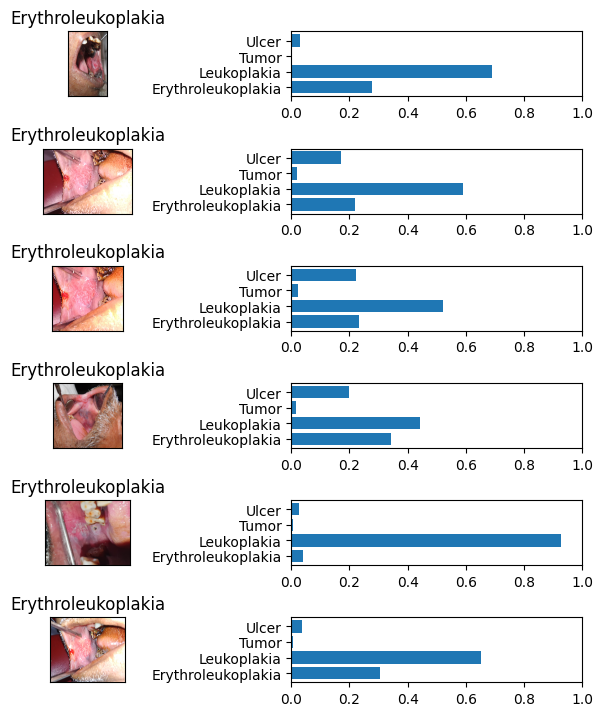

In [43]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 200))

for idx, data in enumerate(zip(test['image_path'].to_list(), test['label'].to_list())):
    if idx >5:
        break
    path,label = data
    image = Image.open(path)
    # print(idx, path, label)

    # show original image
    fig.add_subplot(len(images), 2, 2*(idx+1)-1 )
    plt.imshow(images[idx])
    plt.xticks([])
    plt.yticks([])
    plt.title(label)

    # show probabilities
    fig.add_subplot(len(images), 2, 2*(idx+1))
    plt.barh(range(len(probs[0].detach().numpy())),probs[idx].detach().numpy(), tick_label=classes)
    plt.xlim(0,1.0)

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.2,
                        hspace=0.8)

plt.show()


In [44]:
probs_ = probs.detach().numpy()
y_true = test['int_label'].to_list()
y_pred = []

labels_mapp = {0:1, 1:3, 2:4, 3:5}

for prob in probs_:
    max_idx = np.argmax(prob)
    y_pred.append(labels_mapp[max_idx])

len(y_true), len(y_pred)

(137, 137)

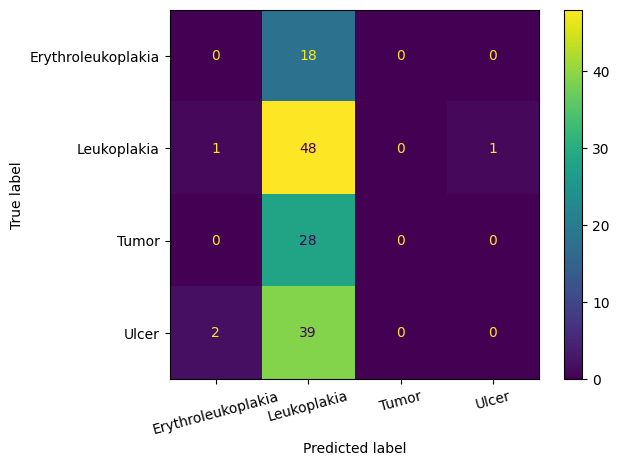

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes, )

disp.plot(xticks_rotation=15)